In [139]:
class ColoredEdgeWeightedGraph(sage.graphs.graph.Graph):
    """a new class for vertex colored and edge weighted graphs"""
    
    def __init__(self, *args, **kwargs ):
        
        if len(args) == 1 and type(args[0]) == ColoredEdgeWeightedGraph:
            super().__init__(args[0])
            ver_colors, edge_weights = args[0].vertex_colors, args[0].edge_weights
        else:
            gr, ver_colors, edge_weights = args[0], args[1], args[2]
            super().__init__( gr )
        
        self.edge_weights = edge_weights
        self.vertex_colors = ver_colors
        for w in edge_weights:
            self.set_edge_label( w[0], w[1], w[2] )

        num_vars = max( ver_colors.keys())+1
        self.fraction_field = PolynomialRing( QQ, 'x', 
               num_vars ).fraction_field()       

    def vertex_color( self, v ):
        for k in self.vertex_colors:
            if v in self.vertex_colors[k]:
                return k
                
    
    def automorphism_group( self ):
        parts = [ self.vertex_colors[k] for k in self.vertex_colors ]
        g = super().automorphism_group( edge_labels = True, partition = parts )
 
        return g

    def canonical_label( self ):
        g, a = super().canonical_label( edge_labels = True, certificate = True )
        max_cols = max( self.vertex_colors.keys())
        cols = { y: [ a[x] for x in self.vertex_colors[y]] for y in [0..max_cols]}
        return  ColoredEdgeWeightedGraph( g, cols, g.edges()), a

    def is_isomorphic( self, gr ):
        c_self, ac = self.canonical_label() 
        c_gr, agr = gr.canonical_label()
        
        if c_self != c_gr:
            return False
        a = super(ColoredEdgeWeightedGraph,c_self).automorphism_group( 
                            edge_labels = True )
        p1 = tuple( set(c_self.vertex_colors[k]) for k in c_self.vertex_colors.keys())
        p2 = tuple( tuple(c_gr.vertex_colors[k]) for k in c_gr.vertex_colors.keys())

        orb = a.orbit( p2, action = "OnTuplesSets" )
        return p1 in orb
    
    def function_V( self ):

        k = self.fraction_field
        vcols = [ self.vertex_color( x ) for x in self.vertices()]
        maxcols = max( self.vertex_colors.keys()) 
        gens = k.gens()
        lam = lambda v:  gens[vcols[v]]

        
        return  product([ product( [ lam(v)-gens[j] for j in [0..maxcols] if 
                        j != vcols[v]])^(len(self.neighbors(v))-1)*
                sum( [ self.edge_label( v, w )/(lam(v)-lam(w)) for 
                        w in self.neighbors(v)])^(len(self.neighbors(v))-3)*
                product( [self.edge_label( v, w )/(lam(v)-lam(w)) for 
                            w in self.neighbors(v)]) for v in self. vertices()])        
            
        
    def function_E( self ):
            
        k = self.fraction_field
        I = k.one()
        Z = k.zero()
        vcols = [ self.vertex_color( x ) for x in self.vertices()]
        gens = k.gens()
        lam = lambda v:  gens[vcols[v]]
        
        nrcols = max( self.vertex_colors.keys() )
        prod = I
        for e in self.edges():
            v, w, de = e[0], e[1], e[2]
            # first factor
            fac1 = (-1)^de*(de/(lam(v)-lam(w)))^(2*de)/factorial(de)^2
        
            # second factor (double product)
            fac2 = I 
            for col in [0..nrcols]:
                if col != vcols[v] and col != vcols[w]:
                    lam0 = gens[col]
                    for alph in range( de+1 ):
                        fac2 *= ((alph*lam(v)+(de-alph)*lam(w))/de-lam0)^-1
            prod *= fac1*fac2

        return prod
    
    def function_Theorem43( self, r ):
        
        k = self.fraction_field
        vcols = [ self.vertex_color( x ) for x in self.vertices()]
        gens = k.gens()
        lam = lambda v: gens[vcols[v]]

        vcols = [ self.vertex_color( x ) for x in self.vertices()]

        return sum([ e[2]*sum([ lam(e[0])^t*lam(e[1])^(r-t) for t in [0..r]]) 
                    for e in self.edges()])


In [140]:
def is_isom_in_list( list, gr ):
    for g in list:
        if gr.is_isomorphic( g ):
            return True
    
    return False

def isom_types_graphs( num_v, num_col,  sum_weight ):

    tr = graphs.trees(num_v)
    grs = []

    for t in tr:    
        cols = sage.graphs.graph_coloring.all_graph_colorings(t,num_col)
        ed = t.edges()
        num_ed = len(ed)
        for col in cols:
            for c in [0..num_col-1]:
                if not c in col:
                    col[c] = []
        
            for p in Partitions( sum_weight, length = num_ed ):
                for w in Arrangements( p, len(p)):                    
                    e_w = [[ed[i][0],ed[i][1],w[i]] for i in range( len( w ))]
                    gr = ColoredEdgeWeightedGraph( t, col, e_w )
                    if not is_isom_in_list( grs, gr ):
                        grs.append( ColoredEdgeWeightedGraph( t, col, e_w))
                

    return grs


In [144]:
grs = isom_types_graphs( 3, 4, 3 )
len(grs)

36

In [56]:
g = grs[6]; print( g.edges(), g.vertex_colors ) 

[(0, 1, 1), (0, 3, 1), (1, 2, 1)] {0: [3], 1: [0], 2: [1], 3: [2]}


In [106]:
from sage.graphs.graph_coloring import all_graph_colorings
G = Graph({0: [1, 2, 3], 1: [2]})
n = 0
m = 0
for C in all_graph_colorings(G, 3, hex_colors=True):
     parts = [C[k] for k in C]
     for P in parts:
         l = len(P)
         for i in range(l):
             for j in range(i + 1, l):
                 if G.has_edge(P[i], P[j]):
                    m += 1
                    raise RuntimeError("Coloring Failed.")
     n+=1
print( "m é ", m )
#print("G has %s 3-coloring" % n)

m é  0


In [105]:
G.is_isomorphic(G, edge_labels = True )

True

In [97]:
cols = all_graph_colorings(G, 3 )
#for col in cols:
#    print( col )

[ col for col in cols ]


[{0: [0], 1: [1, 3], 2: [2]},
 {0: [0], 1: [1], 2: [2, 3]},
 {0: [0], 2: [1], 1: [2, 3]},
 {0: [0], 2: [1, 3], 1: [2]},
 {1: [0], 0: [1, 3], 2: [2]},
 {1: [0], 0: [1], 2: [2, 3]},
 {1: [0], 2: [1], 0: [2, 3]},
 {1: [0], 2: [1, 3], 0: [2]},
 {2: [0], 0: [1, 3], 1: [2]},
 {2: [0], 0: [1], 1: [2, 3]},
 {2: [0], 1: [1], 0: [2, 3]},
 {2: [0], 1: [1, 3], 0: [2]}]

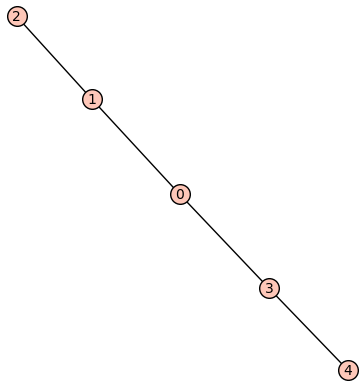

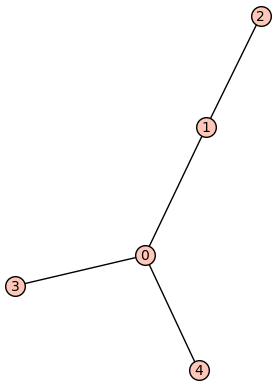

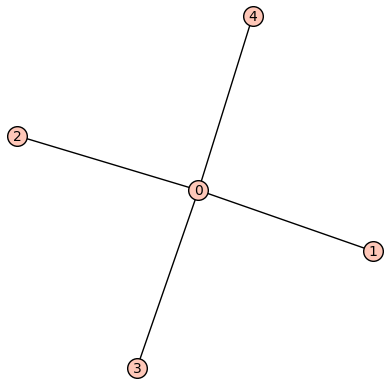

[None, None, None]

In [68]:
tr = graphs.trees(5)
trs = []
while True:
    try:
        trs.append( next( tr ))
    except:
        break

[t.show() for t in trs ]

In [60]:
#g.automorphism_group( edge_labels = True )

In [61]:
for d in [[2,1,1],[1,0,1],[0,4,2],[0,3,2]]:
    g.set_edge_label( d[0], d[1], d[2] )

g.edges()

gr = g.automorphism_group( edge_labels = True )
gr

NameError: name 'g' is not defined

In [269]:
#cols = sage.graphs.graph_coloring.all_graph_colorings(g, 3)
col = next(cols)
col
#labels(col)

{0: [0], 1: [1, 3, 4], 2: [2]}

In [276]:
#g.automorphism_group( edge_labels = True )
gr = g.automorphism_group()#edge_labels = True, partition = [[0,2],[1,3],[4]] )
col = { 0: [0], 1: [1,3], 2: [4,2] }
#gr.orbit( [[0],[1,3],[4,2]], action = "OnSets" )

In [220]:
g = ColoredEdgeWeightedGraph( g, [[0,2],[1,4,3]], [[2,1,1],[1,0,0],[0,4,2],[0,3,0]])
g.ver_colors

[[0, 2], [1, 4, 3]]

In [22]:
g.set_edge_label( 0, 3, 1 )
g.set_edge_label( 0, 4, 2 )
g.edges()
g.automorphism_group( edge_labels = True )

Permutation Group with generators [()]

In [206]:
class ColoredEdgeWeightedGraph(Graph):
    """a new class for vertex colored and edge weighted graphs"""
    
    def __init__(self, gr, ver_colors, edge_weights ):
        super().__init__( gr.edges() )
        self.ver_colors = ver_colors
        for w in edge_weights:
            self.set_edge_label( w[0], w[1], w[2] )
    
    def automorphism_group_with_cols( self ):
        g = self.automorphism_group( edge_labels = True )
        for cclass in self.ver_colors:
            g = g.stabilizer( cclass, action = "OnSets" )
            
        return g

In [165]:
g.automorphism_group()

Permutation Group with generators [(0,1)(2,3)]

In [166]:
c

{0: [0, 2, 4, 7], 1: [1, 3, 5], 2: [6]}

In [125]:
def translate_list( list ):
    return [ list[x] for x in range(len(list)-1)] + [list[len(list)-1]]

def stabilizer_of_list( g, list ):
    dom = g.domain()
    sym_group_list = PermutationGroup( [[list[1], list[0]], translate_list( list )])
    return g.intersection( sym_group_list )                                        

In [167]:
p = SetPartitions( 9 )

In [168]:
p[1]

{{1, 2, 3, 4, 5, 6, 7, 8}, {9}}

In [109]:
{1,2}

{1, 2}

In [111]:
a = Permutation((1,2))

In [112]:
a

[2, 1]

In [114]:
{ a.action( x ) for x in p[1] }

ValueError: len(a) must equal len(self)

In [116]:
{ x for x in p[1]}

{frozenset({9}), frozenset({1, 2, 3, 4, 5, 6, 7, 8})}

In [132]:
{ x for x in a.action( p[1] )} == { x for x in p[1] }

True

In [133]:
p[1]

{{1, 2, 3, 4, 5, 6, 7, 8}, {9}}

In [32]:
col = sage.graphs.graph_coloring.all_graph_colorings(g,4)

In [56]:
def graph_colors(g,k):
    col = sage.graphs.graph_coloring.all_graph_colorings(g,k)
    cols = []
    while True:
        try:
            c = next(col)
            col_classes = [ c[x] for x in c.keys()]
            col_classes.sort()
            if not col_classes in cols:
                cols.append( col_classes )
        except StopIteration:
            break
            
    return cols
    

In [61]:
graph_colors(g,6)

[[[0, 2, 4, 6], [1, 5, 3, 7]],
 [[0, 2, 4, 6], [1, 5, 3], [7]],
 [[0, 2, 4, 7], [1, 5, 3], [6]],
 [[0, 2, 4], [1, 5, 3, 7], [6]],
 [[0, 2, 4], [1, 5, 3], [6], [7]],
 [[0, 2, 6], [1, 5, 3, 7], [4]],
 [[0, 2, 6], [1, 5, 3], [4, 7]],
 [[0, 2, 6], [1, 5, 3], [4], [7]],
 [[0, 2, 7], [1, 5, 3], [4, 6]],
 [[0, 2], [1, 5, 3, 7], [4, 6]],
 [[0, 2], [1, 5, 3], [4, 6], [7]],
 [[0, 2, 7], [1, 5, 3], [4], [6]],
 [[0, 2], [1, 5, 3, 7], [4], [6]],
 [[0, 2], [1, 5, 3], [4, 7], [6]],
 [[0, 2], [1, 5, 3], [4], [6], [7]],
 [[0, 2, 4, 6], [1, 5, 7], [3]],
 [[0, 2, 4, 6], [1, 5], [3, 7]],
 [[0, 2, 4, 6], [1, 5], [3], [7]],
 [[0, 2, 4, 7], [1, 5], [3, 6]],
 [[0, 2, 4], [1, 5, 7], [3, 6]],
 [[0, 2, 4], [1, 5], [3, 6], [7]],
 [[0, 2, 4, 7], [1, 5], [3], [6]],
 [[0, 2, 4], [1, 5, 7], [3], [6]],
 [[0, 2, 4], [1, 5], [3, 7], [6]],
 [[0, 2, 4], [1, 5], [3], [6], [7]],
 [[0, 2, 6], [1, 5, 4, 7], [3]],
 [[0, 2, 6], [1, 5, 4], [3, 7]],
 [[0, 2, 6], [1, 5, 4], [3], [7]],
 [[0, 2, 7], [1, 5, 4], [3, 6]],
 [[0, 2], [1,

In [8]:
c = next(col)
len(c)

3

In [13]:
cols = []
cols.append(1)

In [14]:
cols

[1]

In [278]:
K.<x,y> = FunctionField( QQ, 2 )

TypeError: create_key() got multiple values for argument 'names'

In [281]:
aInv_poly = PolynomialRing(QQ,'a2,a4,a6')
aInv = aInv_poly.fraction_field()

In [282]:
aInv

Fraction Field of Multivariate Polynomial Ring in a2, a4, a6 over Rational Field

In [283]:
aInv.inject_variables()

Defining a2, a4, a6


In [287]:
(a2+a4)/(a4+a6)

(a2 + a4)/(a4 + a6)